In [1]:
import torch
import torch.nn as nn
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
from torch.autograd.function import Function
import numpy as np
import torch.utils.data as Data
import math
from torch.utils.data import DataLoader
import torch.optim as optim
import copy
import time
from torch.optim import Adam
import pandas as pd
import numpy as np
import sklearn.metrics as metrics
from collections import Counter
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import SMOTE
from torch.cuda.amp import autocast as autocast
from torch.cuda.amp import GradScaler
import matplotlib.pyplot as plt

from torch import randperm
from sklearn.utils import resample
import numpy as np
from sklearn.model_selection import train_test_split


# 忽略烦人的红色提示
import warnings
warnings.filterwarnings("ignore")

import argparse

In [2]:
if(torch.cuda.is_available()):
    device = torch.device("cuda")
    print("使用GPU训练中：{}".format(torch.cuda.get_device_name()))
else:
    device = torch.device("cpu")

使用GPU训练中：NVIDIA GeForce RTX 4090


In [3]:
# train_x_list = "C:/Users/Savior/Desktop/wisdm/HAR-datasets/OPPORTUNITY/x_train.npy"
# train_y_list = "C:/Users/Savior/Desktop/wisdm/HAR-datasets/OPPORTUNITY/y_train.npy"
# test_x_list = "C:/Users/Savior/Desktop/wisdm/HAR-datasets/OPPORTUNITY/x_test.npy"
# test_y_list = "C:/Users/Savior/Desktop/wisdm/HAR-datasets/OPPORTUNITY/y_test.npy"

In [4]:

# class HAR_BorderlineSMOTE(Data.Dataset):
#     def __init__(self, filename_x, filename_y):
#         self.filename_x = filename_x
#         self.filename_y = filename_y
#
#     def HAR_data(self):
#
#         data_x_raw = np.load(self.filename_x)
#         data_x=data_x_raw
#         data_y = np.load(self.filename_y)
#         data_x = torch.tensor(data_x, dtype=torch.float32)
#         data_y = torch.tensor(data_y, dtype=torch.long)
#         smo = BorderlineSMOTE(random_state=42,kind="borderline-1")
#         n, nx, ny = data_x.shape
#         data_x = data_x.reshape((n,nx*ny))
#         data_x, data_y = smo.fit_resample(data_x, data_y)
#         data_x = data_x.reshape((data_x.shape[0],nx,ny))
#
#         print(Counter(data_y))
#         train_data, val_data, train_label, val_label = train_test_split(data_x, data_y, test_size=0.1, random_state=42)
#         print(train_data.shape)
#         print(val_data.shape)
#
#         torch_dataset=[]
#         torch_dataset = Data.TensorDataset(torch.from_numpy(train_data), torch.from_numpy(train_label)), Data.TensorDataset(torch.from_numpy(val_data), torch.from_numpy(val_label))
#         return torch_dataset
#
# class trian_HAR(Data.Dataset):
#     def __init__(self, filename_x):
#         self.filename_x = filename_x
#         # self.filename_y = filename_y
#
#     def HAR_data(self):
#         data_x_raw, data_y = np.load(self.filename_x)
#
#         data_x=data_x_raw  # (N, C, H, W) (7352, 1, 128, 9)
#         # data_x = np.expand_dims(data_x_raw, 1)
#         # data_y = np.load(self.filename_y)
#         train_data, val_data, train_label, val_label = train_test_split(data_x, data_y, test_size=0.1, random_state=42)
#         torch_dataset=[]
#         tr1 = torch.from_numpy(train_data)
#         tl1 = torch.from_numpy(train_label)
#         va1 = torch.from_numpy(val_data)
#         vl1 = torch.from_numpy(val_label)
#         # print(tr1.shape)
#         tr1 = tr1.permute(0, 2, 1)
#         va1 = va1.permute(0, 2, 1)
#         print(tl1.shape)
#         torch_dataset = Data.TensorDataset(tr1, torch.from_numpy(train_label)), Data.TensorDataset(va1, torch.from_numpy(val_label))
#
#         return torch_dataset
#
# class HAR(Data.Dataset):
#     def __init__(self, filename_x):
#         self.filename_x = filename_x
#         # self.filename_y = filename_y
#
#     def HAR_data(self):
#         data_x_raw, data_y = np.load(self.filename_x)
#
#         data_x=data_x_raw  # (N, C, H, W) (7352, 1, 128, 9)
#         # data_x = np.expand_dims(data_x_raw, 1)
#         # data_y = np.load(self.filename_y)
#         tr1 = torch.from_numpy(data_x)
#         tr1 = tr1.permute(0, 2, 1)
#
#         torch_dataset = Data.TensorDataset(tr1, torch.from_numpy(data_y))
#         return torch_dataset
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
parser = argparse.ArgumentParser()
parser.add_argument('-f', type=str, default="读取额外的参数")
parser.add_argument('--bs', type=int, default=256, help='Batch size')
parser.add_argument('--float', type=int, default=5e-4, help='Learning rate')
parser.add_argument('--epoch', type=int, default=200, help='Epoch')
args = parser.parse_args(args=[])
#load data
train_x = torch.from_numpy(np.load('/root/HAR/dataset/WISDM/x_train.npy')).float()
train_y = torch.from_numpy(np.load('/root/HAR/dataset/WISDM/y_train.npy')).long()
test_x = torch.from_numpy(np.load('/root/HAR/dataset/WISDM/x_test.npy')).float()
test_y = torch.from_numpy(np.load('/root/HAR/dataset/WISDM/y_test.npy')).long()

# train_x = torch.unsqueeze(train_x, 1)
# test_x = torch.unsqueeze(test_x, 1)
# train_x = train_x.reshape(train_x.size(0), 1, train_x.size(1), train_x.size(2))
# test_x = test_x.reshape(test_x.size(0), 1, test_x.size(1),test_x.size(2))
num_classes = len(Counter(train_y.tolist()))
len_train, len_test = len(train_y),  len(test_y)

train_data, val_data, train_label, val_label = train_test_split(train_x, train_y, test_size=0.15)

train_dataset = Data.TensorDataset(train_data, train_label)
val_dataset = Data.TensorDataset(val_data, val_label)
test_dataset = Data.TensorDataset(test_x, test_y)

train_loader = Data.DataLoader(dataset=train_dataset, batch_size=args.bs, shuffle=True)
test_loader = Data.DataLoader(dataset=test_dataset, batch_size=args.bs, shuffle=True)
val_loader = Data.DataLoader(dataset=val_dataset, batch_size=args.bs, shuffle=True)

In [5]:
print(train_y.shape)

torch.Size([43924])


In [6]:
print(test_y.shape)

torch.Size([10982])


In [7]:
# data_train= trian_HAR(x_list)
# train_dataset,val_dataset = data_train.HAR_data()

In [8]:
data_loader = Data.DataLoader(dataset=train_dataset, batch_size=1024, shuffle=True)
for data, label in data_loader:
    print(data.size())  # 输出第一个样本的大小
    break

torch.Size([1024, 90, 3])


In [9]:
# #数据上采样部分
# data_train= trian_HAR(train_x_list, train_y_list)
# train_dataset,val_dataset = data_train.HAR_data()
# data_test = HAR(test_x_list, test_y_list)
# test_dataset = data_test.HAR_data()

In [10]:
from sklearn.metrics import classification_report
def test(model, test_dataloader):
    # 将模型设置为测试模式.
    model.eval()
    # 定义损失函数.
    criterion = nn.CrossEntropyLoss()

    # 在测试集上测试模型.
    test_loss = 0.0
    test_correct = 0
    test_total = 0
    y_true = []
    y_pred = []
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_dataloader):
            # 将输入和标签数据转换为Tensor并放到GPU上（如果有的话）.
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 前向传播.
            outputs = model(inputs)
            # 计算损失和准确率.
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            test_correct += (predicted == labels).sum().item()
            test_total += labels.size(0)
            # 累计测试损失.
            test_loss += loss.item()

    # 计算测试准确率和损失.
    test_acc = 100.0 * test_correct / test_total
    test_loss = test_loss / len(test_dataloader)

    # 打印测试结果.
    print('Test Loss: {:.4f}, Test Acc: {:.2f}%'.format(test_loss, test_acc))
    # 返回测试结果.
    return test_loss, test_acc

In [11]:
if(torch.cuda.is_available()):
    device = torch.device("cuda")
    print("使用GPU训练中：{}".format(torch.cuda.get_device_name()))
else:
    device = torch.device("cpu")
    print("使用CPU训练")

使用GPU训练中：NVIDIA GeForce RTX 4090


In [12]:
class SEModule(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEModule, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc1 = nn.Conv1d(channels, channels // reduction, kernel_size=1, padding=0)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Conv1d(channels // reduction, channels, kernel_size=1, padding=0)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input):
        x = self.avg_pool(input)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return input * x

In [13]:
class AdaptiveReweight(nn.Module):
    def __init__(self, channel, reduction=4,momentum=0.1,index=0):
        self.channel=channel
        super(AdaptiveReweight, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.LayerNorm([channel // reduction]),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )
        self.register_buffer('running_scale', torch.zeros(1))
        self.momentum=momentum
        self.ind=index
        

    def forward(self, x):
        b, c, _, _ = x.size()
        _x=x.view(b,c,-1)
        x_var=_x.var(dim=-1)

        y = self.fc(x_var).view(b, c)

        if self.training:
            scale=x_var.view(-1).mean(dim=-1).sqrt()
            self.running_scale.mul_(1. - self.momentum).add_(scale.data*self.momentum)
        else:
            scale=self.running_scale
        inv=(y/scale).view(b,c,1,1)
        return inv.expand_as(x)*x  
    
class CE(nn.Module):
    def __init__(self, num_features, pooling=False, num_groups=1, num_channels=64, T=3, dim=4, eps=1e-5, momentum=0,
                    *args, **kwargs):
        super(CE, self).__init__()
        self.T = T
        self.eps = eps
        self.momentum = momentum
        self.num_features = num_features
        self.dim = dim

        if num_channels is None:
            num_channels = (num_features - 1) // num_groups + 1
        num_groups = num_features // num_channels
        while num_features % num_channels != 0:
            num_channels //= 2
            num_groups = num_features // num_channels
        assert num_groups > 0 and num_features % num_groups == 0, "num features={}, num groups={}".format(num_features,
            num_groups)
        self.num_groups = num_groups
        self.num_channels = num_channels
        shape = [1] * dim
        shape[1] = self.num_features

        self.AR=AdaptiveReweight(num_features)
        self.pool=None
        if pooling:
            self.pool=nn.MaxPool2d(2,stride=2)
    
        self.register_buffer('running_mean', torch.zeros(num_groups, num_channels, 1))

        self.register_buffer('running_wm', torch.eye(num_channels).expand(num_groups, num_channels, num_channels))
        self.x_weight = nn.Parameter(torch.zeros(1))
        print(self.num_channels)

    def forward(self, X):
        N,C,H,W=X.size()
        xin=self.AR(X)
        x_pool=self.pool(X) if self.pool is not None else X
        
        x_pool=x_pool.transpose(0, 1).contiguous().view(self.num_groups, self.num_channels, -1)
        x = X.transpose(0, 1).contiguous().view(self.num_groups, self.num_channels, -1)
        _, d, m = x.size()
        
        if self.training:
            mean = x_pool.mean(-1, keepdim=True)
            
            xc = x_pool - mean
            
            P = [None] * (self.T + 1)
            P[0] = torch.eye(d,device=X.device).expand(self.num_groups, d, d)
            Sigma = torch.baddbmm(alpha=self.eps, input=P[0], beta=1. / m, batch1=xc, batch2=xc.transpose(1, 2))

            rTr = (Sigma * P[0]).sum((1, 2), keepdim=True).reciprocal_()
            Sigma_N = Sigma * rTr
            for k in range(self.T):
                mat_power3=torch.matmul(torch.matmul(P[k],P[k]),P[k])
                P[k + 1] = torch.baddbmm(alpha=1.5, input=P[k], beta=-0.5, batch1=mat_power3, batch2=Sigma_N)
            
            wm = P[self.T]  

            self.running_mean.mul_(1. - self.momentum).add_(mean.data*self.momentum)
            self.running_wm.mul_((1. - self.momentum)).add_(self.momentum * wm.data)
        else:
            xc = x - self.running_mean
            wm = self.running_wm

        xn = wm.matmul(x)
        Xn = xn.view(X.size(1), X.size(0), *X.size()[2:]).transpose(0, 1).contiguous()

        x_weight=torch.sigmoid(self.x_weight)
        return x_weight*Xn+(1-x_weight)*xin
    

class WISDM_CE(nn.Module):
    def __init__(self, num_class=6):
        super(WISDM_CE, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU(True)
        self.pool1 = nn.MaxPool2d(kernel_size=(3, 1), stride=(3, 1))

        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.bn2 = nn.BatchNorm2d(128)
        self.relu2 = nn.ReLU(True)
        self.pool2 = nn.MaxPool2d(kernel_size=(3, 1), stride=(3, 1))

        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.bn3 = nn.BatchNorm2d(256)
        # self.relu3 = nn.ReLU(True)
        self.pool3 = nn.MaxPool2d(kernel_size=(3, 1), stride=(3, 1))
        self.ce3 = CE(num_features=256, pooling=False, num_channels=256)

        self.fc = nn.Linear(2304, num_class)

    def forward(self, x):
        x = x.unsqueeze(1)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.pool1(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu2(out)
        out = self.pool2(out)

        out = self.conv3(out)
        out = self.bn3(out)
        # out = self.relu3(out)
        out = self.pool3(out)
        out = self.ce3(out)

        out = out.view(out.size(0), -1)
        out = self.fc(out)
        out = nn.LayerNorm(out.size())(out.cpu())
        out = out.cuda(0)
        # out = F.normalize(out.cuda(0))

        return out

In [14]:

def get_conv2d(in_channels, out_channels, kernel_size, stride, padding, dilation, groups, bias):
    if type(kernel_size) is int:
        use_large_impl = kernel_size > 5
    else:
        assert len(kernel_size) == 2 
        use_large_impl = kernel_size[0] > 5
    has_large_impl = 'LARGE_KERNEL_CONV_IMPL' in os.environ
    if has_large_impl and in_channels == out_channels and out_channels == groups and use_large_impl and stride == 1 and padding == kernel_size // 2 and dilation == 1:
        return nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride,
                         padding=padding, dilation=dilation, groups=in_channels, bias=bias)
    else:
        return nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride,
                         padding=padding, dilation=dilation, groups=groups, bias=bias)

def get_bn(channels):
    return nn.BatchNorm2d(channels)

def conv_bn(in_channels, out_channels, kernel_size, stride, padding, groups, dilation=1):
    if padding is None:
        if type(kernel_size) == tuple:
            padding = (kernel_size[0] // 2,kernel_size[1] // 2)
        elif type(kernel_size) == int:
            padding = kernel_size // 2
    result = nn.Sequential()
    result.add_module('conv', get_conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size,
                                         stride=stride, padding=padding, dilation=dilation, groups=groups, bias=False))
    result.add_module('bn', get_bn(out_channels))
    return result

def conv_bn_relu(in_channels, out_channels, kernel_size, stride, padding, groups, dilation=1):
    if padding is None:
        if type(kernel_size) == tuple:
            padding = (kernel_size[0] // 2,kernel_size[1] // 2)
        elif type(kernel_size) == int:
            padding = kernel_size // 2
    result = conv_bn(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size,
                                         stride=stride, padding=padding, groups=groups, dilation=dilation)
    result.add_module('nonlinear', nn.ReLU())
    return result

def fuse_bn(conv, bn):
    kernel = conv.weight
    running_mean = bn.running_mean
    running_var = bn.running_var
    gamma = bn.weight
    beta = bn.bias
    eps = bn.eps
    std = (running_var + eps).sqrt()
    t = (gamma / std).reshape(-1, 1, 1, 1)
    return kernel * t, beta - running_mean * gamma / std

class ReparamLargeKernelConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size,
                 stride, groups,
                 small_kernel,
                 small_kernel_merged=False):
        super(ReparamLargeKernelConv, self).__init__()
        self.kernel_size = kernel_size
        self.small_kernel = small_kernel
   
        if type(kernel_size) == tuple:
            padding = (kernel_size[0] // 2,kernel_size[1] // 2)
        elif type(kernel_size) == int:
            padding = kernel_size // 2
        if small_kernel_merged:
            self.lkb_reparam = get_conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size,
                                          stride=stride, padding=padding, dilation=1, groups=groups, bias=True)
        else:
            self.lkb_origin = conv_bn(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size,
                                      stride=stride, padding=padding, dilation=1, groups=groups)
            if small_kernel is not None:
                assert small_kernel <= kernel_size, 'The kernel size for re-param cannot be larger than the large kernel!'
                self.small_conv = conv_bn(in_channels=in_channels, out_channels=out_channels, kernel_size=small_kernel,
                                             stride=stride, padding=small_kernel//2 if type(small_kernel) == int else (small_kernel[0]//2,small_kernel[1]//2), groups=groups, dilation=1)

    def forward(self, inputs):
        if hasattr(self, 'lkb_reparam'): 
            out = self.lkb_reparam(inputs)
        else:
            out = self.lkb_origin(inputs)
            if hasattr(self, 'small_conv'):
                out += self.small_conv(inputs)
        return out

    def get_equivalent_kernel_bias(self):
        eq_k, eq_b = fuse_bn(self.lkb_origin.conv, self.lkb_origin.bn)
        if hasattr(self, 'small_conv'):
            small_k, small_b = fuse_bn(self.small_conv.conv, self.small_conv.bn)
            eq_b += small_b
            eq_k += nn.functional.pad(small_k, [(self.kernel_size - self.small_kernel) // 2] * 4)
        return eq_k, eq_b

    def merge_kernel(self):
        eq_k, eq_b = self.get_equivalent_kernel_bias()
        self.lkb_reparam = get_conv2d(in_channels=self.lkb_origin.conv.in_channels,
                                     out_channels=self.lkb_origin.conv.out_channels,
                                     kernel_size=self.lkb_origin.conv.kernel_size, stride=self.lkb_origin.conv.stride,
                                     padding=self.lkb_origin.conv.padding, dilation=self.lkb_origin.conv.dilation,
                                     groups=self.lkb_origin.conv.groups, bias=True)
        self.lkb_reparam.weight.data = eq_k
        self.lkb_reparam.bias.data = eq_b
        self.__delattr__('lkb_origin')
        if hasattr(self, 'small_conv'):
            self.__delattr__('small_conv')


class ELK(nn.Module):
    def __init__(self, in_channels, dw_channels, block_lk_size, small_kernel,small_kernel_merged=True):
        super().__init__()
        self.pw1 = conv_bn_relu(in_channels, dw_channels, 1, 1, 0, groups=1)
        self.large_kernel = ReparamLargeKernelConv(in_channels=dw_channels, out_channels=dw_channels, kernel_size=block_lk_size,
                                                  stride=1, groups=dw_channels, small_kernel=small_kernel, small_kernel_merged=small_kernel_merged)
        self.lk_nonlinear = nn.ReLU()
        self.pw2 = conv_bn(dw_channels, dw_channels, 1, 1, 0, groups=1)
        self.prelkb_bn = get_bn(dw_channels)
       

        self.short = nn.Sequential()
        if (in_channels != dw_channels):
            self.short = nn.Sequential(
                 nn.Conv2d(in_channels,dw_channels,1),
                 nn.ReLU(),
            )


    def forward(self, x):
        out = self.pw1(x)
        out = self.large_kernel(out)
        out = self.lk_nonlinear(out)
        out = self.pw2(out)     
        return  self.short(x) + (out)
    
class ELK_CNN(nn.Module):
    def __init__(self, train_shape, category):
        super(ELK_CNN, self).__init__()
       
        self.layer = nn.Sequential(
            nn.Conv2d(1,64, (6, 1), (2, 1), (1, 0)),
            nn.BatchNorm2d(64),
            nn.ReLU(),


            ELK(64,128,(31,1),(3,1)),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128,256, (6, 1), (2, 1), (1, 0)),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        self.ada_pool = nn.AdaptiveAvgPool2d((1, train_shape[-1]))
        self.fc = nn.Linear(256*train_shape[-1], category)
        
    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.layer(x)
        x = self.ada_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    def structural_reparam(self):
        for m in self.modules():
            if hasattr(m, 'merge_kernel'):
                m.merge_kernel()

In [15]:


class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.fc1   = nn.Conv2d(in_planes, in_planes // 16, 1, bias=False)
        self.relu1 = nn.ReLU()
        self.fc2   = nn.Conv2d(in_planes // 16, in_planes, 1, bias=False)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc2(self.relu1(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.relu1(self.fc1(self.max_pool(x))))
        out = avg_out + max_out
        return self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()

        assert kernel_size in (3, 7), 'kernel size must be 3 or 7'
        padding = 3 if kernel_size == 7 else 1

        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)



class resnet(nn.Module):
    def __init__(self):
        super(resnet, self).__init__()

        # print(channel_in, channel_out,  kernel, stride, bias,'channel_in, channel_out, kernel, stride, bias')
        self.Block1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=128, kernel_size=(6, 1), stride=(2, 1), padding=(0, 0)),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0)),
            nn.BatchNorm2d(128),
            nn.ReLU(True)
        )
        self.shortcut1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=128, kernel_size=(6, 1), stride=(2, 1), padding=(0, 0)),
            nn.BatchNorm2d(128),
        )
        self.ca1 = ChannelAttention(128)
        self.sa1 = SpatialAttention()

        self.Block2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(6, 1), stride=(2, 1), padding=(0, 0)),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0)),
            nn.BatchNorm2d(256),
            nn.ReLU(True)
        )
        self.shortcut2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(6, 1), stride=(2, 1), padding=(0, 0)),
            nn.BatchNorm2d(256),
        )
        self.ca2 = ChannelAttention(256)
        self.sa2 = SpatialAttention()

        self.Block3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=384, kernel_size=(6, 1), stride=(2, 1), padding=(0, 0)),
            nn.BatchNorm2d(384),
            nn.ReLU(True),
            nn.Conv2d(in_channels=384, out_channels=384, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0)),
            nn.BatchNorm2d(384),
            nn.ReLU(True)
        )
        self.shortcut3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=384, kernel_size=(6, 1), stride=(2, 1), padding=(0, 0)),
            nn.BatchNorm2d(384),
        )
        self.ca3 = ChannelAttention(384)
        self.sa3 = SpatialAttention()

        self.fc = nn.Sequential(
            nn.Linear(8064, 6)
        )

    def forward(self, x):
        x = x.unsqueeze(1)
        # print(x.shape)
        h1 = self.Block1(x)
        # print(h1.shape)
        r = self.shortcut1(x)
        # print(r.shape)
        h1 = self.ca1(h1) * h1
        h1=  self.sa1(h1) * h1
        h1 = h1 + r
        # print(h1.shape)
        h2 = self.Block2(h1)
        # print(h2.shape)
        r = self.shortcut2(h1)
        # print(r.shape)
        h2 = self.ca2(h2) * h2
        h2 = self.sa2(h2) * h2
        h2 = h2 + r
        # print(h2.shape)
        h3 = self.Block3(h2)
        # print(h3.shape)
        r = self.shortcut3(h2)
        # print(r.shape)
        h3 = self.ca3(h3) * h3
        h3 = self.sa3(h3) * h3
        h3 = h3 + r
        x = h3.view(h3.size(0), -1)
        # print(x.shape)
        x = self.fc(x)
        x = nn.LayerNorm(x.size())(x.cpu())
        x = x.cuda()

        return x


# Model




In [16]:
# batch_size = 128 #renext
batch_size = 512
train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, pin_memory=True, shuffle=True,drop_last=True, num_workers=1,)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, pin_memory=True, shuffle=True, num_workers=1,)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=batch_size, pin_memory=True, shuffle=True, num_workers=1,)


In [17]:
def compute_gmean(predictions, labels):
    # 根据预测结果计算TP、FN、TN、FP
    # 这里的示例代码假设预测结果是二分类的概率值

    y_pred = np.argmax(predictions, axis=0)
    y_true = labels

    TP = np.sum((y_pred == 1) & (y_true == 1))
    FN = np.sum((y_pred == 0) & (y_true == 1))
    TN = np.sum((y_pred == 0) & (y_true == 0))
    FP = np.sum((y_pred == 1) & (y_true == 0))

    # 计算Sensitivity和Specificity
    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)

    # 计算G-mean
    gmean = np.sqrt(sensitivity * specificity)

    return gmean

In [18]:
def train(model, train_dataloader,val_dataloader, num_epochs=50, lr1 = 0.001,lr2 = 0.003,loss_weight = 0.007,batch_size=1024):
    # 定义损失函数和优化器.
    criterion1 = nn.CrossEntropyLoss()
    #criterion2 = CenterLoss(6, 6).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr1)
    #optimizer1 = Lion(model.parameters(), lr = lr1, weight_decay=1.0)
    #optimizer2 = Lion(criterion2.parameters(), lr = lr2, weight_decay=1.0)

    # train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, pin_memory=True, shuffle=True,drop_last=True, num_workers=2,)
    # val_dataloader = DataLoader(dataset=val_dataset, batch_size=batch_size, pin_memory=True, shuffle=True, num_workers=2,)

    # 定义存储训练和验证结果的列表.
    train_loss_list = []
    train_acc_list = []
    val_loss_list = []
    val_acc_list = []


    # 定义在验证集上表现最好的模型准确率和损失.
    best_val_acc = 0.0
    best_val_loss = float('inf')
    Best_epoch=0
    # 定义存储最佳模型参数的变量.
    best_model_params = None
    # 开始训练模型.
    for epoch in range(num_epochs):
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        model.train()
        for i, (inputs, labels) in enumerate(train_dataloader):
            model.train()
            # 将输入和标签数据转换为Tensor并放到GPU上（如果有的话）.
            inputs = inputs.to(device)
            labels = labels.to(device)
            # print(labels.shape)

            # 将梯度清零.
            optimizer.zero_grad()
            #optimizer1.zero_grad()
            #optimizer2.zero_grad()

            # 前向传播.
            outputs = model(inputs)

            # 计算损失和准确率.
            loss = criterion1(outputs, labels)#+loss_weight*criterion2(labels,outputs,)
            _, predicted = torch.max(outputs.data, 1)
            train_correct += (predicted == labels).sum().item()
            train_total += labels.size(0)

            # 反向传播和更新参数.
            loss.backward()
            optimizer.step()
            #optimizer1.step()
            #optimizer1.step()
            # 累计训练损失
            train_loss += loss.item()
            print(">",end="")
        # 计算训练准确率和损失.
        train_acc = 100.0 * train_correct / train_total
        train_loss = train_loss / len(train_dataloader)

        # 在验证集上验证模型.
        val_loss = 0.0
        val_correct = 0
        val_total = 0






        with torch.no_grad():

            for i, (inputs, labels) in enumerate(val_dataloader):
                # 将输入和标签数据转换为Tensor并放到GPU上（如果有的话）.
                model.eval()
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 前向传播.
                outputs = model(inputs)

                # 计算损失和准确率.
                loss = criterion1(outputs, labels)#+loss_weight*criterion2(labels,outputs,)
                _, predicted = torch.max(outputs.data, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

                # 累计验证损失.
                val_loss += loss.item()


        # 计算验证准确率和损失.
        val_acc = 100.0 * val_correct / val_total
        val_loss = val_loss / len(val_dataloader)
        if val_acc > best_val_acc or (val_acc == best_val_acc and val_loss < best_val_loss):
            Best_epoch =epoch+1
            best_val_acc = val_acc
            best_val_loss = val_loss
            best_model_params = model.state_dict()

        print()


        # 打印训练和验证结果.
        print('Epoch [{}/{}], Train Loss: {:.4f}, Train Acc: {:.2f}%, Val Loss: {:.4f}, Val Acc: {:.2f}%'
              .format(epoch+1, num_epochs, train_loss, train_acc, val_loss, val_acc))

        # 保存训练和验证结果.
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        val_loss_list.append(val_loss)
        val_acc_list.append(val_acc)
    print("The best epoch:",Best_epoch,"    Acc:",best_val_acc)
    model.load_state_dict(best_model_params)
    # 返回训练和验证结果.
    return model.eval(),train_loss_list, train_acc_list, val_loss_list, val_acc_list

In [19]:
#from torchsummary import summary
#summary(model, (90,3))
#Model(x=train_dataloader).to(device)\6
#model =  resnext50_32x4d(num_classes=6, include_top=True).to(device)
#model = LSTM_CNN(input_dim=3, hidden_dim=16, num_layers=1, num_classes=6)

#model = CNN(input_channel=3, num_classes=6).to(device)
#model = CNN_GRU(input_dim=3,hidden_dim=512,num_classes=6)
#model = LSTM(input_size=3, hidden_size=200, num_layers=1, output_size=6)
# model = SC_CNN(input_dim=3, num_classes=6)
# model = CNNAttention(input_dim=3, num_classes=6)
# model = SelfAttention(input_dim=36, num_classes=18)
# model =  resnet34(num_classes=6, include_top=True).to(device)
# model = ResBiLSTM(input_size=36, hidden_size=32, num_layers=3, num_classes=18)
#model =  ATT(row=0, col=0, num_classes=6).to(device)
#model = ELK_CNN(train_shape=[batch_size,90,3],category=6).to(device)
#model = WISDM_CE().to(device)
model = resnet().to(device)
#model = CNN_biGRU(input_dim=3,hidden_dim=16,num_classes=6)


In [20]:
# layer_params = model.linear.parameters()
#
# # 打印每个参数的设备信息
# for param in layer_params:
#     print("Parameter device:", param.device)

In [21]:
#criterion1 = nn.CrossEntropyLoss()
#criterion2 = CenterLoss(6, 6).to(device)
#optimizer1 = optim.Adam(model.parameters(),lr=lr1)
#optimizer2 = optim.Adam(criterion2.parameters(), lr=lr2)
#optimizer1 = Lion(model.parameters(), lr = lr1, weight_decay=1.0)
#optimizer2 = Lion(criterion2.parameters(), lr = lr2, weight_decay=1.0)
start_time = time.time()

# model,train_loss_list, train_acc_list, val_loss_list, val_acc_list=train(model, train_dataloader, val_dataloader, num_epochs=30,lr1 = 0.008,lr2 = 0.003,loss_weight = 0.007)
# model,train_loss_list, train_acc_list, val_loss_list, val_acc_list=train(model, train_dataloader, val_dataloader, num_epochs=30,lr1 = 0.008,lr2 = 0.003,loss_weight = 0.007) #LSTM-CNN
model,train_loss_list, train_acc_list, val_loss_list, val_acc_list=train(model, train_dataloader, val_dataloader, num_epochs=50,lr1 = 0.001,lr2 = 0.003,loss_weight = 0,batch_size=512)
end_time = time.time()
use_time= end_time - start_time
print("Train and val complete in {:.0f}m {:.0f}s".format(use_time // 60, use_time % 60))

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Epoch [1/50], Train Loss: 0.8145, Train Acc: 75.89%, Val Loss: 0.6705, Val Acc: 83.34%
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Epoch [2/50], Train Loss: 0.5199, Train Acc: 88.95%, Val Loss: 0.5314, Val Acc: 88.22%
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Epoch [3/50], Train Loss: 0.4413, Train Acc: 93.42%, Val Loss: 0.4246, Val Acc: 94.58%
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Epoch [4/50], Train Loss: 0.4032, Train Acc: 95.19%, Val Loss: 0.4820, Val Acc: 91.35%
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Epoch [5/50], Train Loss: 0.3872, Train Acc: 95.95%, Val Loss: 0.4075, Val Acc: 95.13%
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Epoch [6/50], Train Loss: 0.3758, Train Acc: 96.41%, Val Loss: 0.3950, Val Acc: 95.42%
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

In [22]:
torch.save(model, 'Dan_wisdm_model.pt')

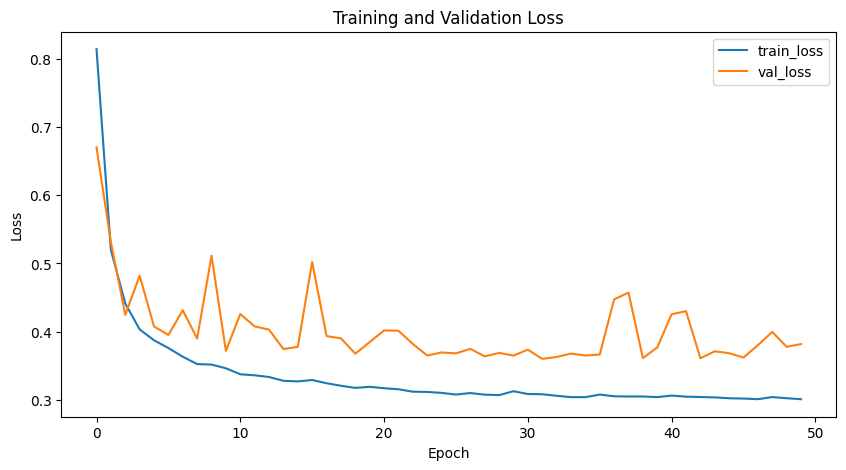

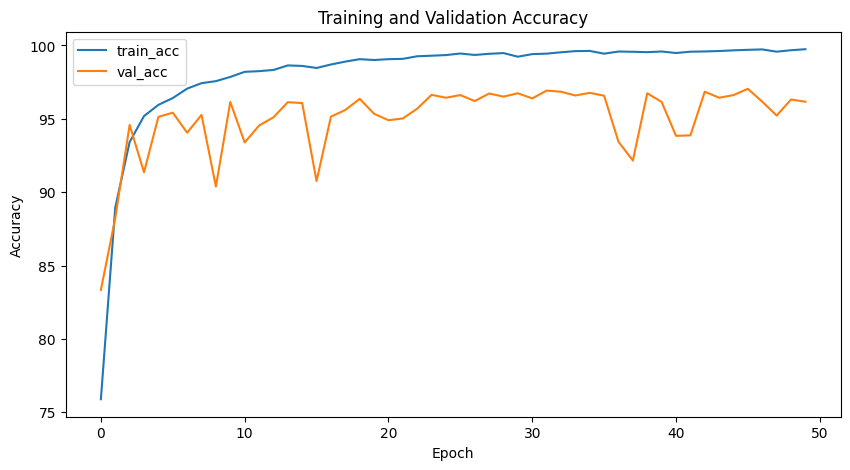

In [23]:
import matplotlib.pyplot as plt


def plot_loss_and_acc(train_loss_list, train_acc_list, val_loss_list, val_acc_list):
    # 绘制训练和验证损失
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss_list, label='train_loss')
    plt.plot(val_loss_list, label='val_loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # 绘制训练和验证准确率
    plt.figure(figsize=(10, 5))
    plt.plot(train_acc_list, label='train_acc')
    plt.plot(val_acc_list, label='val_acc')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
plot_loss_and_acc(train_loss_list, train_acc_list, val_loss_list, val_acc_list)

In [24]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import classification_report
def test_final(model, test_dataloader,loss_weight = 0.007):
    # 将模型设置为测试模式.
    model.eval()

       # 定义损失函数和优化器.
    criterion1 = nn.CrossEntropyLoss()
    #criterion2 = CenterLoss(6, 6).to(device)

    loss_weight=0.007
    # 在测试集上测试模型.
    test_loss = 0.0
    test_correct = 0
    test_total = 0
    y_true = []
    y_pred = []

    num_classes = 6

    conf_matrix = np.zeros((num_classes, num_classes), dtype=int)  # 创建混淆矩阵

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_dataloader):
            # 将输入和标签数据转换为Tensor并放到GPU上（如果有的话）.
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 前向传播.
            outputs = model(inputs)
            pre_lab = torch.argmax(outputs, 1)
            # 计算损失和准确率.
            #loss = criterion1(outputs, labels)
            loss = criterion1(outputs, labels)# + loss_weight * criterion2(labels, outputs)
            _, predicted = torch.max(outputs.data, 1)
            test_correct += (predicted == labels).sum().item()
            test_total += labels.size(0)

            # 累计测试损失.
            test_loss += loss.item()
            y_true.extend(labels.tolist())
            y_pred.extend(pre_lab.tolist())

            # 更新混淆矩阵
            conf_matrix += confusion_matrix(labels.cpu(), pre_lab.cpu(), labels=range(num_classes))

    report = classification_report(y_true, y_pred, digits=4)
    # 计算测试准确率和损失.
    test_acc = 100.0 * test_correct / test_total
    test_loss = test_loss / len(test_dataloader)

    g_mean = np.sqrt(np.diag(conf_matrix) / np.sum(conf_matrix, axis=1))
    g_mean = np.mean(g_mean)

    # 更新分类报告
    report += '\nG-mean: {:.4f}'.format(g_mean)

    # 打印测试结果.
    # print('Test Loss: {:.4f}, Test Acc: {:.2f}%'.format(test_loss, test_acc))
    print('Test Loss: {:.4f}, Test Acc: {:.2f}%, G-mean: {:.4f}'.format(test_loss, test_acc, g_mean))
    print(report)
    # 返回测试结果.
    return test_loss, test_acc, g_mean

In [25]:
test_loss, test_acc, g_mean=test_final(model, test_dataloader,loss_weight = 0)

Test Loss: 0.3822, Test Acc: 96.06%, G-mean: 0.9751
              precision    recall  f1-score   support

           0     0.7473    0.9664    0.8429      1013
           1     0.9905    0.9905    0.9905      3481
           2     0.9932    0.9832    0.9882       596
           3     0.9717    0.9979    0.9846       482
           4     0.9613    0.8039    0.8756      1173
           5     0.9968    0.9705    0.9835      4237

    accuracy                         0.9606     10982
   macro avg     0.9435    0.9521    0.9442     10982
weighted avg     0.9667    0.9606    0.9615     10982

G-mean: 0.9751


In [26]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from matplotlib.ticker import PercentFormatter

class DrawConfusionMatrix:
    def __init__(self, labels_name, normalize=True):
        self.normalize = normalize
        self.labels_name = labels_name
        self.num_classes = len(labels_name)
        self.matrix = np.zeros((self.num_classes, self.num_classes), dtype="float32")
        self.class_counts_matrix = np.zeros((self.num_classes, self.num_classes), dtype="int32")

    def update(self, labels, predicts):
        for predict, label in zip(labels, predicts):
            self.matrix[label, predict] += 1
            self.class_counts_matrix[label, predict] += 1

    def getMatrix(self, normalize=True):
        if normalize:
            per_sum = self.matrix.sum(axis=1)  # 计算每行的和，用于百分比计算
            for i in range(self.num_classes):
                self.matrix[i] = (self.matrix[i] / per_sum[i])  # 百分比转换
            self.matrix = np.around(self.matrix, 4)  # 保留4位小数点
            self.matrix[np.isnan(self.matrix)] = 0.0  # 可能存在NaN，将其设为0
        return self.matrix

    def drawMatrix(self):
        self.matrix = self.getMatrix(self.normalize)
        font = FontProperties(family='serif', style='normal', weight='normal', size=10)
        plt.figure(dpi=480)
        plt.imshow(self.matrix, cmap=plt.cm.Blues)  # 仅画出颜色格子，没有值
        plt.title("PAMAP2", fontproperties=font)  # 标题
        plt.xlabel("Predict label", fontproperties=font)
        plt.ylabel("Truth label", fontproperties=font)

        plt.yticks(range(self.num_classes), self.labels_name, fontproperties=font)  # y轴标签
        plt.xticks(range(self.num_classes), self.labels_name, rotation=0, fontproperties=font)  # x轴标签
        thresh = self.matrix.max() / 2.

        for x in range(self.num_classes):
            for y in range(self.num_classes):
                count = self.class_counts_matrix[y, x]
                #value = str(format('%.2f' % float(self.matrix[y, x] * 100.00))) + '%'  # 数值处理
                #text = f"{count}\n{value}"
                text = count
                plt.text(x, y, text, verticalalignment='center',
                         horizontalalignment='center',
                         color="white" if self.matrix[y, x] > thresh else "black", fontproperties=font, fontsize=6)  # 写值
#                 plt.text(x, y+0.13, value, verticalalignment='center',
#                          horizontalalignment='center',
#                          color="white" if self.matrix[y, x] > thresh else "black", fontproperties=font, fontsize=8)  # 写值

        plt.tight_layout()  # 自动调整子图参数，使之填充整个图像区域

        #色条
        plt.clim(0, 1.0)
        plt.colorbar(format=PercentFormatter(xmax=1, decimals=0, symbol='%', is_latex=False))
        plt.savefig('./ConfusionMatrix.png', bbox_inches='tight')  # bbox_inches='tight'可确保标签信息显示全
        plt.show()


def printMatrix(test_loader, model):
#     labels_name = ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']
#     labels_name=["Walking", "Upstairs", "Downstairs", "Sitting", "Standing", "Laying"]
    labels_name=["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"]

    drawconfusionmatrix = DrawConfusionMatrix(labels_name=labels_name)  # 实例化
    for index, (imgs, labels) in enumerate(test_loader, 1):
        labels_pd = model(imgs.float())
        predict_np = np.argmax(labels_pd.cpu().detach().numpy(), axis=-1)  # array([0,5,1,6,3,...],dtype=int64)
        labels_np = labels.numpy()  # array([0,5,0,6,2,...],dtype=int64)
        drawconfusionmatrix.update(labels_np, predict_np)  # 将新批次的predict和label更新（保存）

    drawconfusionmatrix.drawMatrix()  # 根据所有predict和label，画出混淆矩阵

    confusion_mat = drawconfusionmatrix.getMatrix()  # 你也可以使用该函数获取混淆矩阵(ndarray)
    print(confusion_mat)

print("开始绘制混淆矩阵")
printMatrix(test_dataloader, model)

开始绘制混淆矩阵


RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor